In [3]:
!pip install tensorflow opencv-python matplotlib

  Using cached tensorflow-2.12.0-cp310-cp310-win_amd64.whl (1.9 kB)
  Using cached opencv_python-4.8.0.74-cp37-abi3-win_amd64.whl (38.1 MB)
  Using cached matplotlib-3.7.1-cp310-cp310-win_amd64.whl (7.6 MB)
  Using cached tensorflow_intel-2.12.0-cp310-cp310-win_amd64.whl (272.8 MB)
  Using cached wrapt-1.14.1-cp310-cp310-win_amd64.whl (35 kB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
  Using cached grpcio-1.56.0-cp310-cp310-win_amd64.whl (4.2 MB)
  Using cached libclang-16.0.0-py2.py3-none-win_amd64.whl (24.4 MB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Using cached protobuf-4.23.3-cp310-abi3-win_amd64.whl (422 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached packaging-23.1-py3-none-any.whl (48 kB)
  Using cached tensorflow_estimator-2.12.0-py2.py3-none-any.whl (440 kB)
  Using cached typing_extensions-4.7.0-py3-none-any.whl (33 kB)
  Using cached numpy-1.23.5-c

ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'C:\\Python310\\Scripts\\normalizer.exe' -> 'C:\\Python310\\Scripts\\normalizer.exe.deleteme'

You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


In [8]:
!pip list

Package            Version
------------------ -------
charset-normalizer 3.1.0
idna               3.4
pip                21.2.4
pyasn1             0.5.0
setuptools         58.1.0
urllib3            1.26.16


You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


In [9]:
pip install --upgrade pip

  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4
Note: you may need to restart the kernel to use updated packages.


In [11]:
import tensorflow as tf
import os
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [12]:
tf.config.list_physical_devices('GPU')

[]

In [13]:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

NameError: name 'PhysicalDevice' is not defined

In [14]:
import cv2
import imghdr

In [41]:
data_dir = 'data'
os.listdir(data_dir)

['nontoxicfolder', 'toxicfolder']

In [42]:
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir):
    print(image_class)


nontoxicfolder
toxicfolder


In [44]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)
           # load data

In [18]:
import numpy as np
from matplotlib import pyplot as plt

In [142]:
data = tf.keras.utils.image_dataset_from_directory('Data')

Found 135 files belonging to 2 classes.


In [143]:
data_iterator = data.as_numpy_iterator()

In [144]:
# get another batch from iterator
batch = data_iterator.next()
#images as numpy arrays
scaled = batch[0] / 255
scaled.max()

1.0

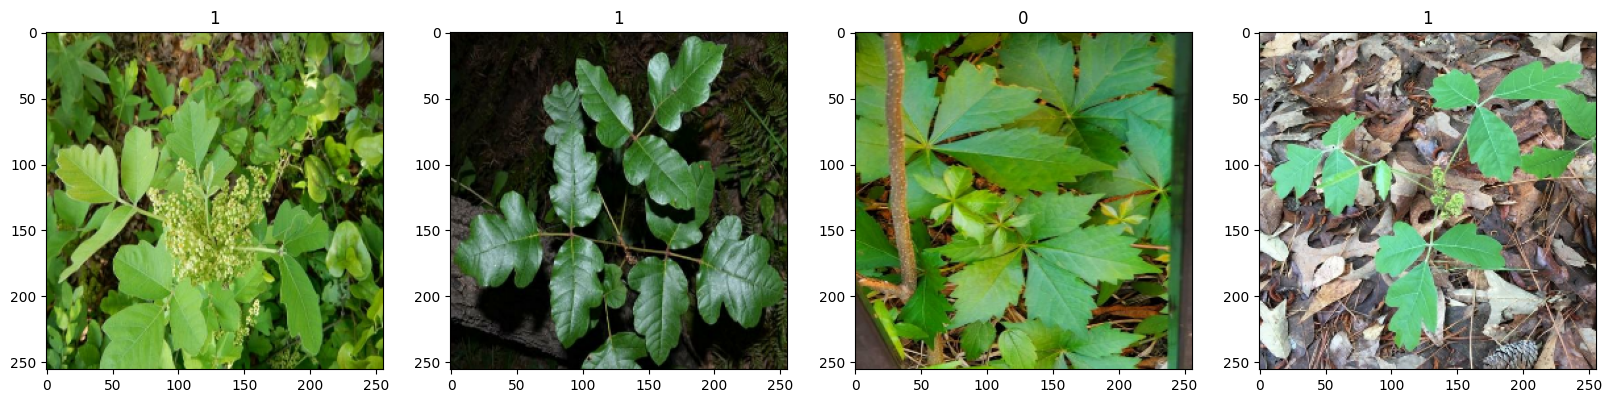

In [145]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    #0 = non toxic 1= toxic

In [146]:
#pre-processing step
# x independent features y is target variable - lables
data = data.map(lambda x,y: (x/255, y))


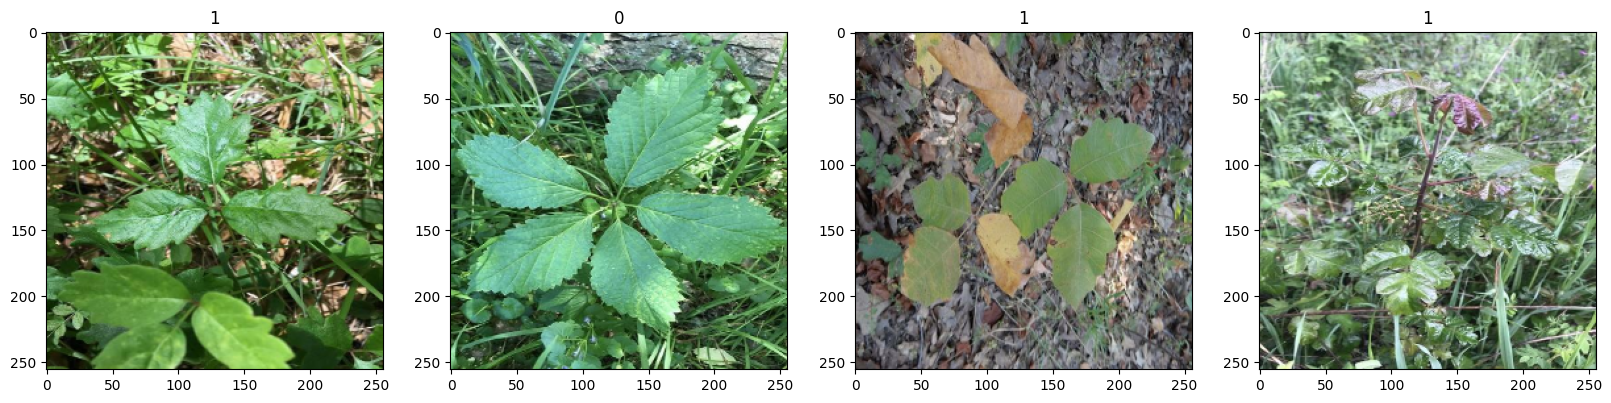

In [147]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])


In [148]:
len(data)
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1


In [149]:

train_size+val_size+test_size

6

In [150]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [151]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [152]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [153]:
model = Sequential()

In [154]:
# convolution has 16 filters, 3 by 3 pixel size, stride of 1, relu take below zero to zero and keeps positive the same
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D()) # condense info
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten()) 
model.add(Dense(256, activation='relu')) # fully connected layers
model.add(Dense(1, activation='sigmoid')) # sigmoid range gets a single output 0 or 1 

In [155]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [156]:
# adam optimizer, specifiy loss and metric accuracy
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

In [157]:
logdir = 'logs'

In [158]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [159]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
3/3 [==============================] - 2s 606ms/step - loss: 1.9661 - accuracy: 0.4792 - val_loss: 0.6307 - val_accuracy: 0.6923
Epoch 2/20
3/3 [==============================] - 2s 555ms/step - loss: 0.8198 - accuracy: 0.3750 - val_loss: 0.7158 - val_accuracy: 0.4615
Epoch 3/20
3/3 [==============================] - 2s 558ms/step - loss: 0.7168 - accuracy: 0.4062 - val_loss: 0.6865 - val_accuracy: 0.6410
Epoch 4/20
3/3 [==============================] - 2s 561ms/step - loss: 0.6846 - accuracy: 0.6146 - val_loss: 0.6530 - val_accuracy: 0.7179
Epoch 5/20
3/3 [==============================] - 2s 558ms/step - loss: 0.6865 - accuracy: 0.5521 - val_loss: 0.6847 - val_accuracy: 0.5128
Epoch 6/20
3/3 [==============================] - 2s 573ms/step - loss: 0.6541 - accuracy: 0.6562 - val_loss: 0.6009 - val_accuracy: 0.6923
Epoch 7/20
3/3 [==============================] - 2s 565ms/step - loss: 0.6419 - accuracy: 0.6146 - val_loss: 0.6425 - val_accuracy: 0.5641
Epoch 8/20
3/3 [====

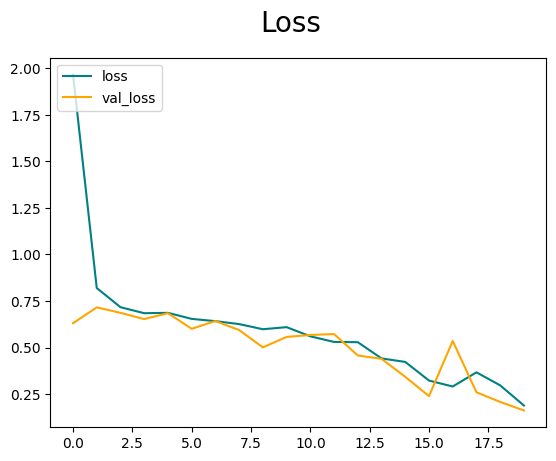

In [160]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

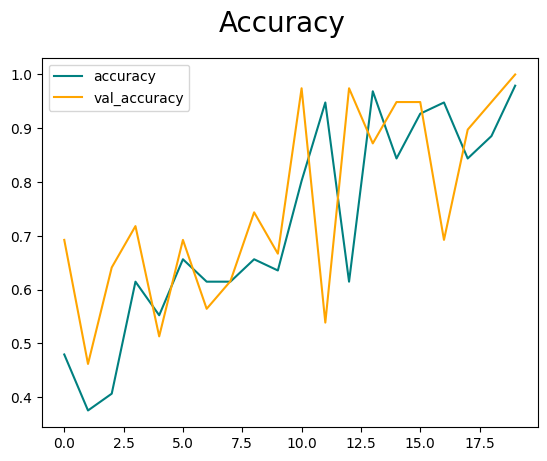

In [161]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [162]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [163]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()


In [164]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    

In [165]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.0, Recall:0.0, Accuracy:0.0


In [166]:
import cv2

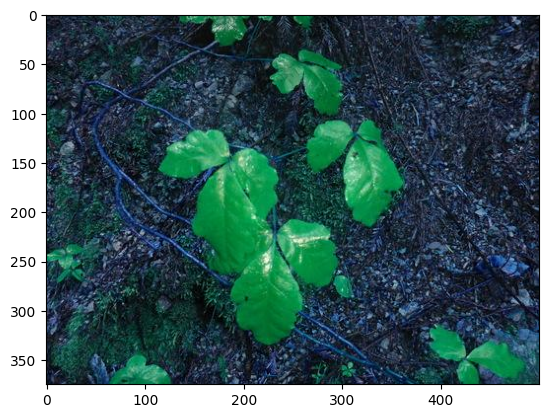

In [167]:
img = cv2.imread('toxictest.jpg')
plt.imshow(img)
plt.show()

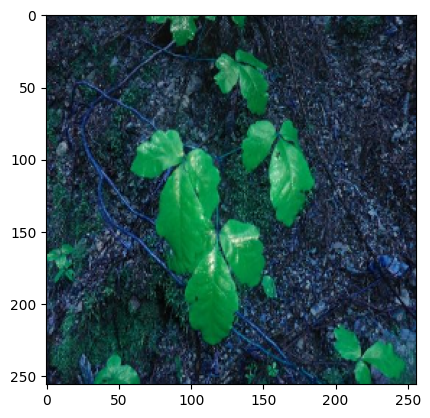

In [168]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [169]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [170]:
yhat

array([[0.6271149]], dtype=float32)

In [171]:
if yhat > 0.5: 
    print(f'Toxic')
else:
    print(f'Non-Toxic')

Toxic


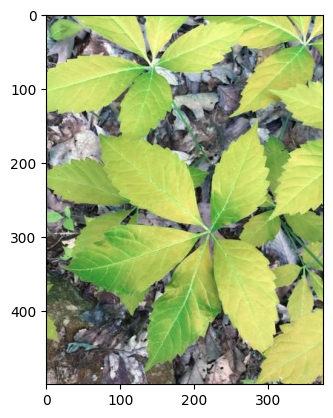

In [172]:
img = cv2.imread('nontoxictest.jpg')
plt.imshow(img)
plt.show()

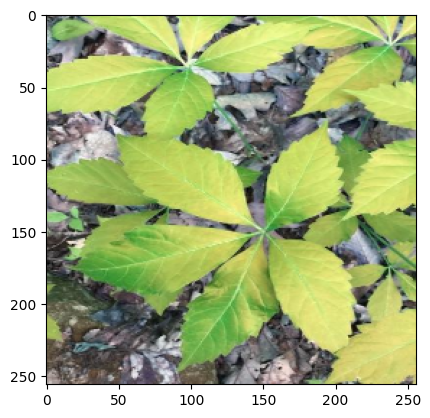

In [173]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [174]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [175]:
yhat

array([[0.4240581]], dtype=float32)

In [176]:
if yhat > 0.5: 
    print(f'Toxic')
else:
    print(f'Non-Toxic')

Non-Toxic
